# Onderzoeksvraag 1
In dit bestand kijk ik dus naar vraag 1 en onderzoek ik:
In hoeverre is de omzet (gross) van een film te voorspellen op basis van de populariteit op Facebook en IMDB?

Dit ga ik doen door dus meerdere modelen te kiezen die ik ga testen daaruit kies ik de gene met de beste resulataten en die ga ik verder trainen.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [36]:
bestand = "dataset/movie-1-cleaned.csv"
df = pd.read_csv(bestand, encoding='utf-8')

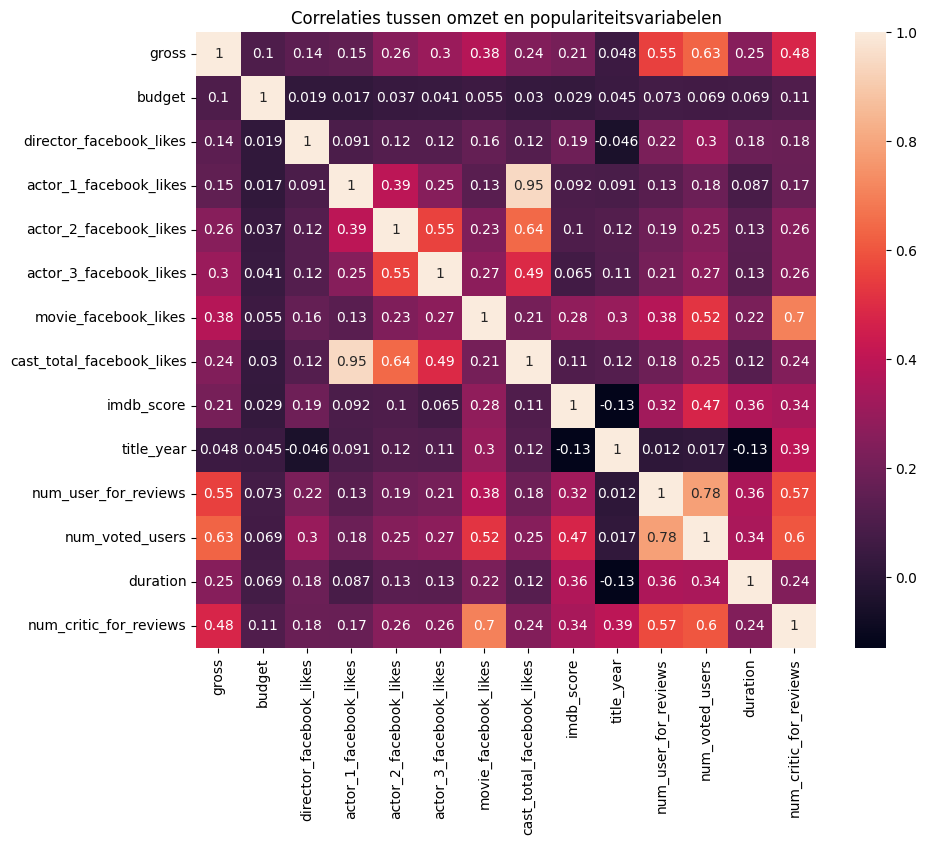

In [37]:
# Beschrijving
df.describe()

# Missende waarden
df.isnull().sum()

# Correlaties
plt.figure(figsize=(10,8))
sns.heatmap(df[['gross', 'budget', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
        'actor_3_facebook_likes','movie_facebook_likes', 'cast_total_facebook_likes', 'imdb_score', 'title_year', 'num_user_for_reviews', 'num_voted_users', 'duration', 'num_critic_for_reviews' ]].corr(), annot=True)
plt.title("Correlaties tussen omzet en populariteitsvariabelen")
plt.show()


Zoals u hierboven kunt zien, is dit een heatmap met alle correlaties. Daarin zien we meteen dat gross een vrij sterke correlatie heeft met de volgende variabelen: budget, director_facebook_likes, actor_1_facebook_likes en title_year.

Ik denk dat het logisch is dat budget een sterke correlatie heeft met gross, want als er veel geld in een film wordt gestoken, is de kans groot dat er ook veel opbrengst tegenover staat.

Daarnaast zien we dat de Facebook-likes ook een duidelijke correlatie laten zien. Dit kan komen doordat beroemde acteurs en regisseurs, die veel mensen kennen en volgen, vaak betrokken zijn bij films die meer verdienen. Bekende namen trekken immers meer publiek, waardoor de gross hoger uitvalt.

Ook is er een duidelijke correlatie met title_year. Ik denk echter dat deze minder waardevol is, omdat — zoals we zagen in de grafiek bij data understanding — films van vroeger simpelweg minder geld opbrachten dan hedendaagse films. Dit komt vooral doordat de filmindustrie tegenwoordig veel groter is. Daarom kunnen we met deze correlatie waarschijnlijk niet heel veel doen in het verdere onderzoek.

Hieronder staan de features die ik heb gekozen om in mijn model te gebruiken. Ik heb meerdere combinaties uitgeprobeerd en met deze selectie kreeg ik de beste resultaten. Verdere uitleg hierover geef ik later in het verslag.

In [38]:
df['log_budget'] = np.log1p(df['budget'])
df['log_gross'] = np.log1p(df['gross'])

df['log_num_user_for_reviews'] = np.log1p(df['num_user_for_reviews'])
df['log_num_voted_users'] = np.log1p(df['num_voted_users'])
df['log_movie_facebook_likes'] = np.log1p(df['movie_facebook_likes'])

df['interaction_budget_imdb'] = df['log_budget'] * df['imdb_score']
df['review_ratio'] = df['log_num_user_for_reviews'] / (df['log_num_voted_users'] + 1e-6)
df['movie_age'] = 2025 - df['title_year']

In [39]:
X = df[['director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
        'actor_3_facebook_likes', 'cast_total_facebook_likes', 'log_movie_facebook_likes',
        'imdb_score', 'log_num_voted_users', 'log_budget', 'log_num_user_for_reviews',
        'num_critic_for_reviews', 'interaction_budget_imdb', 'review_ratio', 'movie_age']]

y = df['log_gross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Gridsearch niet runnen

In [111]:
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
    'max_depth': [10, 15, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': ['sqrt', 'log2', 0.5, None],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,                # aantal combinaties (meer = grondiger)
    cv=5,                     # 5-fold cross validation
    scoring='r2',             # R² score als metric
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\nBeste parameters:")
print(random_search.best_params_)

best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)
r2_best = r2_score(y_test, y_pred)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nRandomForest na tuning -> R²: {r2_best:.3f}, RMSE: {rmse_best:.3f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Beste parameters:
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 50, 'bootstrap': True}

RandomForest na tuning -> R²: 0.634, RMSE: 1.334


## Model keuzen
Ik heb meerdere modellen geprobeerd om de omzet van films te voorspellen. Uiteindelijk ben ik uitgekomen bij een Random Forest-model.

Enkele redenen voor deze keuze zijn:

1. Robuustheid tegen outliers en niet-lineaire relaties: Random Forest kan goed omgaan met variabelen die niet lineair correleren met de target (gross) en is minder gevoelig voor uitschieters.

2. Automatische feature selectie: Het model kan automatisch belangrijke features identificeren, waardoor minder relevante variabelen minder invloed hebben op de voorspelling.

3. Gemakkelijk te implementeren en interpreteren: Random Forest is relatief eenvoudig te trainen en te evalueren, en het biedt inzicht in feature importance.

Wel zijn er enkele beperkingen:

1. Het model overfit soms, vooral bij een relatief kleine dataset of bij veel features.

2. De algehele prestaties zijn niet perfect; betere resultaten lukten met de beschikbare data en tijd niet.

3. Random Forest kan grote modellen genereren die veel geheugen en rekentijd vergen, wat de snelheid van experimenten beïnvloedt.

Ondanks deze beperkingen leverde het Random Forest-model de beste resultaten van de modellen die ik heb getest, en daarom heb ik ervoor gekozen dit model verder te gebruiken in mijn onderzoek.
Hieronder staan de andere modelen die ik heb geprobeerd.

## Modelen geprobeerd 
### Lineair modelen
Linear Regression

Ridge Regression

Lasso Regression 

ElasticNet

### Boomgebaseerde modellen
Decision Tree

Random Forest

Extra Trees

Gradient Boosting

### Niet-lineair model
KNN Regressor

In [40]:
rf = RandomForestRegressor(
     n_estimators=800,
    min_samples_split=5,       
    min_samples_leaf=2,
    max_features='sqrt',        
    max_depth=20,
    bootstrap=True,            
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R²: {r2_rf:.3f}, RMSE: {rmse_rf:.3f}")


R²: 0.622, RMSE: 1.356


Hieronder reken ik de RMSE om naar dollar zodat ik een beter beeld krijg hoeveel ik er naast zit.

In [41]:
# Voorspellingen terug naar echte dollars
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred)

# Bereken R² en RMSE in echte dollars
r2_rf = r2_score(y_test_real, y_pred_real)
rmse_rf = np.sqrt(mean_squared_error(y_test_real, y_pred_real))


print(f"RMSE: ${rmse_rf:,.0f}")

# Gemiddelde fout en procentuele fout
avg_error = np.mean(np.abs(y_test_real - y_pred_real))
pct_error = np.mean(np.abs(y_test_real - y_pred_real) / y_test_real) * 100

print(f"Gemiddelde fout: ${avg_error:,.0f}")
print(f"Gemiddelde procentuele fout: {pct_error:.2f}%")


RMSE: $48,695,463
Gemiddelde fout: $26,589,439
Gemiddelde procentuele fout: 891.65%


## Problemen met het model
Omdat ik tijdens het trainen van het model problemen had om goede resultaten te krijgen en het model ook overfit was, heb ik de volgende maatregelen genomen zodat het model betrouwbaarder wordt:

Overfitting verminderen
→ beperk de diepte van bomen, verhoog min_samples_split en min_samples_leaf, beperk aantal features per split.

Model verbeteren
→ optimaliseer aantal bomen (n_estimators) en de manier van splitsen (max_features).

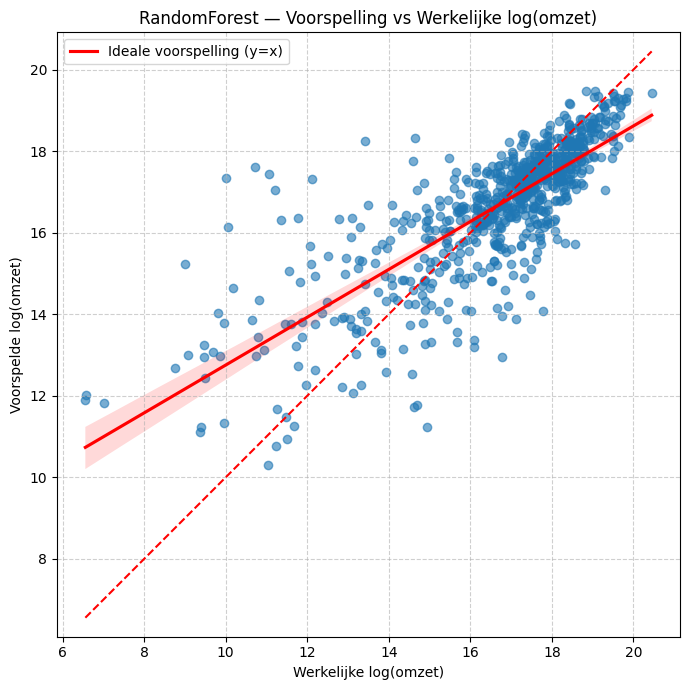

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot van werkelijke vs voorspelde waarden
plt.figure(figsize=(7,7))

# Scatterplot met regressielijn
sns.regplot(
    x=y_test,
    y=y_pred,
    line_kws={'color': 'red', 'label': 'Ideale voorspelling (y=x)'},
    scatter_kws={'alpha': 0.6}
)

# Diagonale lijn (perfecte voorspelling)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Labels en titel
plt.xlabel("Werkelijke log(omzet)")
plt.ylabel("Voorspelde log(omzet)")
plt.title("RandomForest — Voorspelling vs Werkelijke log(omzet)")

# Asverhouding gelijk voor correcte vergelijking
plt.axis('equal')

# Raster en legenda
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot weergeven
plt.show()


In deze grafiek kan je zien wat de ideale voorspelling is en elke film die voorspeld is.

In [43]:
cv_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print(f"Gemiddelde cross-val R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

Gemiddelde cross-val R²: 0.331 ± 0.077


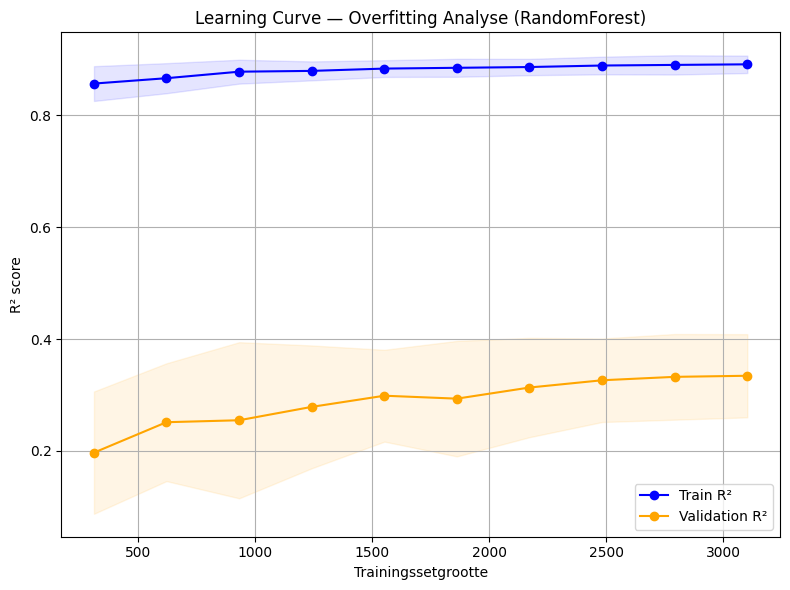

In [44]:
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Gemiddelde en standaarddeviatie
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
test_mean  = test_scores.mean(axis=1)
test_std   = test_scores.std(axis=1)

# Plotten
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='orange', label='Validation R²')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

plt.xlabel("Trainingssetgrootte")
plt.ylabel("R² score")
plt.title("Learning Curve — Overfitting Analyse (RandomForest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In deze grafiek zien we snel dat het model erg overfit is.

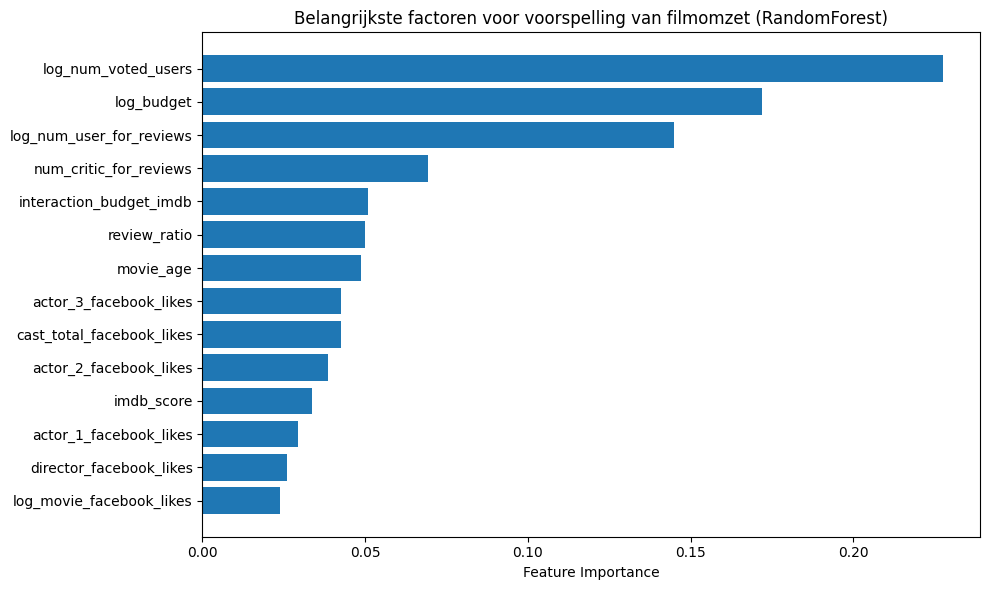

In [45]:
importances = rf.feature_importances_
feature_names = X.columns

# DataFrame met importances
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plotten
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()  # Belangrijkste bovenaan
plt.xlabel("Feature Importance")
plt.title("Belangrijkste factoren voor voorspelling van filmomzet (RandomForest)")
plt.tight_layout()
plt.show()

In de grafiek zien we de belangrijkste factoren die het RandomForest-model gebruikt om de omzet van films te voorspellen. Het valt meteen op dat log_num_voted_users de hoogste feature-importance heeft. Dit betekent dat het aantal mensen dat een film heeft beoordeeld op IMDB een sterke indicator is voor de omzet.

Dit is logisch: films met veel stemmen hebben vaak een grotere zichtbaarheid en een bredere doelgroep, wat vaak leidt tot hogere opbrengsten. Hoe meer mensen een film beoordelen, hoe groter de kans dat het publiek geïnteresseerd is en de film daadwerkelijk gaat kijken.

Daarnaast zijn ook log_budget en log_num_user_for_reviews belangrijke factoren. Dit ondersteunt het idee dat zowel het budget als de betrokkenheid van het publiek via reviews een grote rol spelen bij het succes van een film.

Interessant is dat de Facebook-likes van acteurs en regisseurs relatief minder invloed hebben in het model, hoewel ze nog steeds bijdragen. Dit suggereert dat online populariteit belangrijk is, maar dat concrete betrokkenheid en belangstelling van het publiek (zoals stemmen en reviews op IMDB) een nog sterkere voorspeller is voor de uiteindelijke omzet.

Verder zien we dat interactievariabelen zoals interaction_budget_imdb en review_ratio ook enigszins bijdragen. Dit laat zien dat combinaties van factoren, zoals een hoog budget en hoge IMDB-score, samen ook waardevol zijn om de omzet beter te voorspellen.

## Resultaten
Als we naar al deze grafieken kijken, zien we snel dat het model niet heel goed presteert. Het behaalt slechts een R² van 0.622 en een RMSE van 1.356 (in log-schaal), wat betekent dat het model ongeveer 62,2% van de variantie in gross kan verklaren.

In echte dollars betekent dit:

- RMSE: $48.695.463

- Gemiddelde fout: $26.589.439

- Gemiddelde procentuele fout: 891,65%

Dit laat zien dat het model gemiddeld zo’n 26,5 miljoen dollar naast de werkelijke opbrengst zit, wat natuurlijk niet ideaal is. Daarnaast zien we ook dat het model sterk overfit, wat inhoudt dat het zich te veel aanpast aan de trainingsdata en minder goed generaliseert naar nieuwe data. Ik heb geprobeerd dit te verminderen door hyperparameters aan te passen, maar helaas had dit slechts beperkt effect.

Het voorspellen van de omzet van een film blijft moeilijk, vooral omdat het model nu alleen gebruikmaakt van Facebook-likes en IMDB-scores. Voor een betere inschatting zou je aanvullende informatie kunnen gebruiken, zoals:

- Beroemdheid van de acteurs en regisseur, aangezien bekende namen vaak meer publiek trekken.

- Vorige films in een serie, omdat franchises vaak een consistente opbrengst hebben.

- Vergelijkbare films met gelijksoortige budgetten, om trends in opbrengst te identificeren.

- Filmstudio, omdat sommige studio’s vaker blockbusters produceren.

Zelfs met deze extra informatie blijft het moeilijk om nieuwe films of films met onbekendere acteurs en regisseurs goed te voorspellen. Daarnaast spelen andere factoren mee:

- Type film: animatiefilms of speciale effecten-films zijn vaak duurder om te maken en kunnen hogere opbrengsten hebben.

- Genre en doelgroep, marketingbudget, releasedatum en concurrentie van andere films kunnen ook grote invloed hebben.

Kortom: het voorspellen van filmomzet is een complex probleem met veel variabelen. Mijn huidige model biedt een indicatie, maar de voorspellingen zijn nog verre van perfect, vooral bij films die afwijken van de gemiddelde trends.